In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset,concatenate_datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def filter_data(data, metric_name, metric_value):    
    if metric_name == 'degree':
        p_in_train = data.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
        p_not_in_train = data.filter(lambda x: ((x['label']==1) & (x['min_angle']>metric_value)))        
        n_in_train = data.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))
        n_not_in_train = data.filter(lambda x: ((x['label']==0) & (x['min_angle']<=metric_value)))
        in_train=concatenate_datasets([p_in_train,n_in_train])
        not_in_train=concatenate_datasets([p_not_in_train,n_not_in_train])        
    elif metric_name == 'distance':
        p_in_train = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']>=metric_value)))
        p_not_in_train = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']<metric_value)))        
        n_in_train = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']<metric_value)))
        n_not_in_train = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']>=metric_value)))        
        in_train=concatenate_datasets([p_in_train,n_in_train])
        not_in_train=concatenate_datasets([p_not_in_train,n_not_in_train])    
    return in_train, not_in_train

In [3]:
def metric_calculation(data):
    gt=data['label']
    pred=data['pred']
    acc=accuracy_score(gt, pred)
    _,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
    fpr=fpc/len(data)
    fnr=fnc/len(data)
    return acc,fpr,fnr

In [4]:
def post_processing(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])
    new_data=data.add_column("pred", pred)
    in_train, not_in_train=filter_data(new_data, metric_name, metric_value)
    
    ## accuracy calculation
    acc,fpr,fnr=metric_calculation(new_data)
    p_acc,_,_=metric_calculation(in_train)
    n_acc,_,_=metric_calculation(not_in_train)
    
    return pred,acc,fpr,fnr,p_acc,n_acc

In [81]:
ds = load_dataset("beanham/spatial_join_dataset")
test=ds['test']
models=['heuristic','llama3','mistral']
metric_names=['degree', 'distance']
predictions={}
results=[]
for model in models:
    for metric_name in metric_names:
        if metric_name=='degree':
            metric_values=[1,2,5,10,20]
        elif metric_name=='distance':
            metric_values=[1,2,3,4,5]        
        for metric_value in metric_values:
            pred,acc,fpr,fnr,id_acc,ood_acc=post_processing(test, model,metric_name,metric_value)
            results.append([model, metric_name, metric_value, acc,fpr,fnr,id_acc,ood_acc])
            predictions[f'{model}_{metric_name}_{metric_value}']=pred
results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr','id_acc','ood_acc'])
results['metric_index']=[f'metric_{i}'for i in range(1,6)]*6
degree_results=results[results['metric']=='degree'].reset_index(drop=True)
distance_results=results[results['metric']=='distance'].reset_index(drop=True)

# Error Analysis
### Accuracy, FPR & FNR

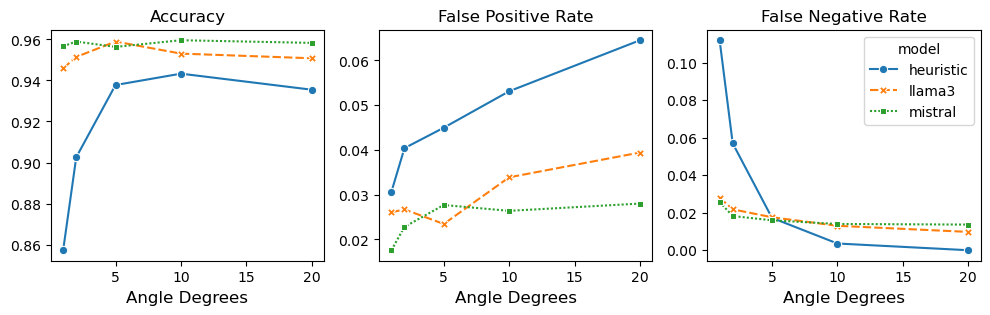

In [77]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=degree_results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=degree_results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=degree_results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('Angle Degrees', fontsize=12)
axs[1].set_xlabel('Angle Degrees', fontsize=12)
axs[2].set_xlabel('Angle Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
pass

With degree being the heuristic metric, we see that:
- Heuristics are value sensitive. A small change used in the heuristic method could lead to 4% change in accuracy. And in reality, it is hard to determine which threshold to use without domain knowledge. Even with domain knowledge, it is hard to determine which value to use given the sensitivity of heuristic method. The best heuristic gives about 0.94 accuracy, which is good.

- Llama3 and Mistral results maintain relatively constant, and higher accuracy than heuristic performance, despite the change in the fine-tuning data. It shows that LLMs are more robust and stable to the change in the data.


- False positive rates increases dramatically with heuristic methods as threshold increases; fprs are lower from llama and mistral models, indicating better performances. We do see slightly elevated false positives on llama3 and mistral, which is consistant as the heuristic method. It indicates that they are learning specific and distinct patterns from each unique set of finetuning data. Similar observation applies to false negative rates.

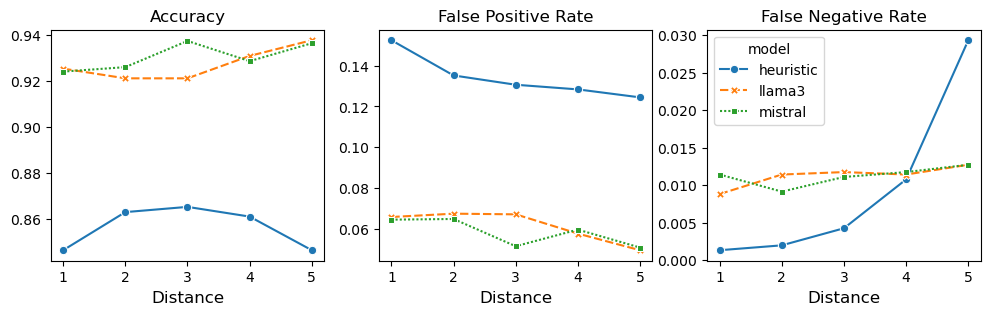

In [79]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=distance_results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=distance_results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=distance_results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('Distance', fontsize=12)
axs[1].set_xlabel('Distance', fontsize=12)
axs[2].set_xlabel('Distance', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
pass

With distance being the heuristic metric, we see that:
- Distance is not a good metric as the degree. The heuristic accuracy are worse than those from degree results. Additionally, the llama and mistral results fine-tuned with distance-filtered data are also worse than those fine-tuned with degree-filtered data. It supports that degree as the heuristic metric is better. And degree-filtered data contains more valuable information for such task. However, it also indicates that LLMs are learning specific and distinct patterns from each unique set of data.

- All the observations from the degree results apply here on the distance results. But we see larger performance gain from the LLMs -- it indicates that even though the distance-filtered data might not be good enough, they can learn and generalize information beyond what they are fine-tuned on to make better predictions.

## In-Distribution (ID) & Out-of-Distribution (OOD) Analysis

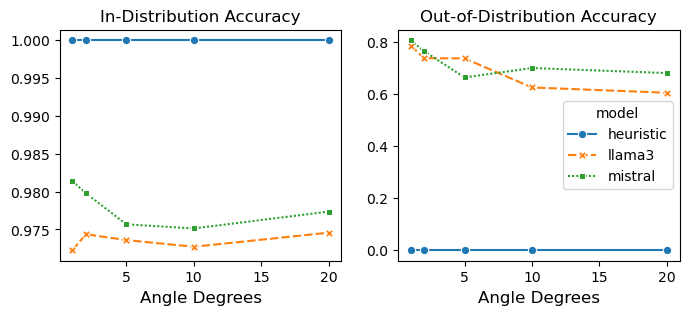

In [86]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=degree_results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=degree_results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Angle Degrees', fontsize=12)
axs[1].set_xlabel('Angle Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass

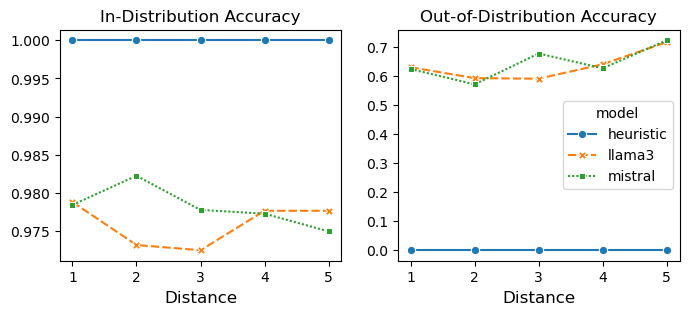

In [87]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=distance_results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=distance_results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Distance', fontsize=12)
axs[1].set_xlabel('Distance', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass